In [5]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Higher Fidelity Graph States
In this notebook, we will prepare quantum circuits for a 7-qubit graph state and estimate the fidelity through stabilizer measurements using Qiskit. In this example, we use the CTMP method of error mitigation and repeat the graph state measurement 16 times to find statistical error bars.

To Do: Modify the graph state preparation circuit or use your own methods of error mitigation to improve the graph state fidelity.


#### Imports

In [6]:
# Qiskit module
from qiskit import QuantumCircuit
import qiskit.circuit.library as circuit_library
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit

# Qiskit tools for noisy simulation
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.utils import insert_noise

# Qiskit tools for running and monitoring jobs
from qiskit import execute
from qiskit.tools.monitor import job_monitor

# Other imports
import numpy as np

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_59/2282276989.py:5: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  import qiskit.ignis.mitigation as mit


#### Preparing Graph States

Here, we prepare the graph state circuit for 7-qubits using the GraphState function in Qiskit's circuit library. We define a graph that uses the connectivity map of the quantum system ibmq_casablanca.


In [7]:
num_qubits = 7

# adjacency matrix for `ibmq_casablanca`
adjmat = [
    [0, 1, 0, 0, 0, 0, 0], 
    [1, 0, 1, 1, 0, 0, 0], 
    [0, 1, 0, 0, 0, 0, 0], 
    [0, 1, 0, 0, 0, 1, 0], 
    [0, 0, 0, 0, 0, 1, 0], 
    [0, 0, 0, 1, 1, 0, 1], 
    [0, 0, 0, 0, 0, 1, 0]]

#### How does it work?

How would you prepare a graph state with high fidelity? In the example below, we create it using Qiskit's circuit library at the gate level. You may explore other methods for creating the graph states, including by using pulse-level techniques or accounting for the errors in the quantum system.


In [8]:
def create_graph_state():
    
    
    
    graph_state_circuit = circuit_library.GraphState(adjmat)
    
    
    
    return graph_state_circuit

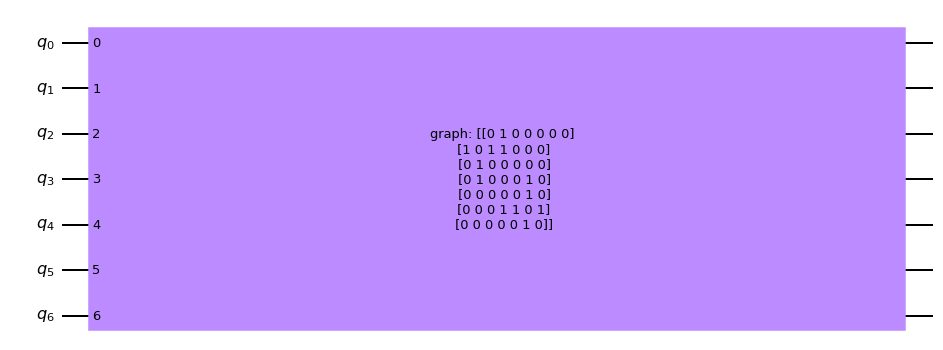

In [9]:
# the graph state can be created using Qiskit's circuit library
state_circuit = create_graph_state()
state_circuit.draw()

#### Creating and measuring stabilizers
We begin by defining functions to create stabilizer measurement circuits, and then appending them onto the circuit used to create the graph states

In [10]:
def compute_stabilizer_group(circuit):
    """Compute the stabilizer group for stabilizer circuit."""
    state = qi.Statevector.from_instruction(circuit)
    labels = []
    for i in qi.pauli_basis(state.num_qubits):
        val = round(qi.state_fidelity(i.to_matrix()[0], state, validate=False))
        if val != 0:
            label = i.to_labels()[0]
            if val == 1:
                label = '+' + label
            else:
                label = '-' + label
            labels.append(label)
    return labels

def stabilizer_coeff_pauli(stabilizer):
    """Return the 1 or -1 coeff and Pauli label."""
    coeff = 1
    pauli = coeff
    if stabilizer[0] == '-':
        coeff = -1
    if stabilizer[0] in ['+', '-']:
        pauli = stabilizer[1:]
    else:
        pauli = stabilizer
    return coeff, pauli

def stabilizer_measure_circuit(stabilizer, initial_circuit=None):
    """Return a stabilizer measurement circuits.
    
    Args:
        stabilizer (str): a stabilizer string
        initial_circuit (QuantumCircuit): Optional, the initial circuit.
    
    Returns:
        QuantumCircuit: the circuit with stabilizer measurements.
    """
    _, pauli = stabilizer_coeff_pauli(stabilizer)
    if initial_circuit is None:
        circ = QuantumCircuit(len(pauli))
    else:
        circ = initial_circuit.copy()
    for i, s in enumerate(reversed(pauli)):
        if s == 'X':
            circ.h(i)
        if s == 'Y':
            circ.sdg(i)
            circ.h(i)
    circ.measure_all()
    return circ

In [11]:
## Compute the stabilizers for this graph state
generators = qi.Clifford(state_circuit).stabilizer.pauli.to_labels()
stabilizers = compute_stabilizer_group(state_circuit)
print('Stabilizers:', stabilizers)
print('Generators:', generators)

Stabilizers: ['+IIIIIII', '+IIIIIZX', '+IIIIXIX', '+IIIIXZI', '-IIIZYXY', '+IIIZYYZ', '+IIIZZXZ', '+IIIZZYY', '+IIXXIIX', '+IIXXIZI', '+IIXXXII', '+IIXXXZX', '-IIXYYXZ', '-IIXYYYY', '-IIXYZXY', '+IIXYZYZ', '+IZIXIIX', '+IZIXIZI', '+IZIXXII', '+IZIXXZX', '-IZIYYXZ', '-IZIYYYY', '-IZIYZXY', '+IZIYZYZ', '+IZXIIII', '+IZXIIZX', '+IZXIXIX', '+IZXIXZI', '-IZXZYXY', '+IZXZYYZ', '+IZXZZXZ', '+IZXZZYY', '+XIIXIIX', '+XIIXIZI', '+XIIXXII', '+XIIXXZX', '-XIIYYXZ', '-XIIYYYY', '-XIIYZXY', '+XIIYZYZ', '+XIXIIII', '+XIXIIZX', '+XIXIXIX', '+XIXIXZI', '-XIXZYXY', '+XIXZYYZ', '+XIXZZXZ', '+XIXZZYY', '+XZIIIII', '+XZIIIZX', '+XZIIXIX', '+XZIIXZI', '-XZIZYXY', '+XZIZYYZ', '+XZIZZXZ', '+XZIZZYY', '+XZXXIIX', '+XZXXIZI', '+XZXXXII', '+XZXXXZX', '-XZXYYXZ', '-XZXYYYY', '-XZXYZXY', '+XZXYZYZ', '+YXYIYXY', '-YXYIYYZ', '-YXYIZXZ', '-YXYIZYY', '-YXYZIII', '-YXYZIZX', '-YXYZXIX', '-YXYZXZI', '-YXZXYXZ', '-YXZXYYY', '-YXZXZXY', '+YXZXZYZ', '-YXZYIIX', '-YXZYIZI', '-YXZYXII', '-YXZYXZX', '-YYYXYXZ', '-YYYXYYY', '-

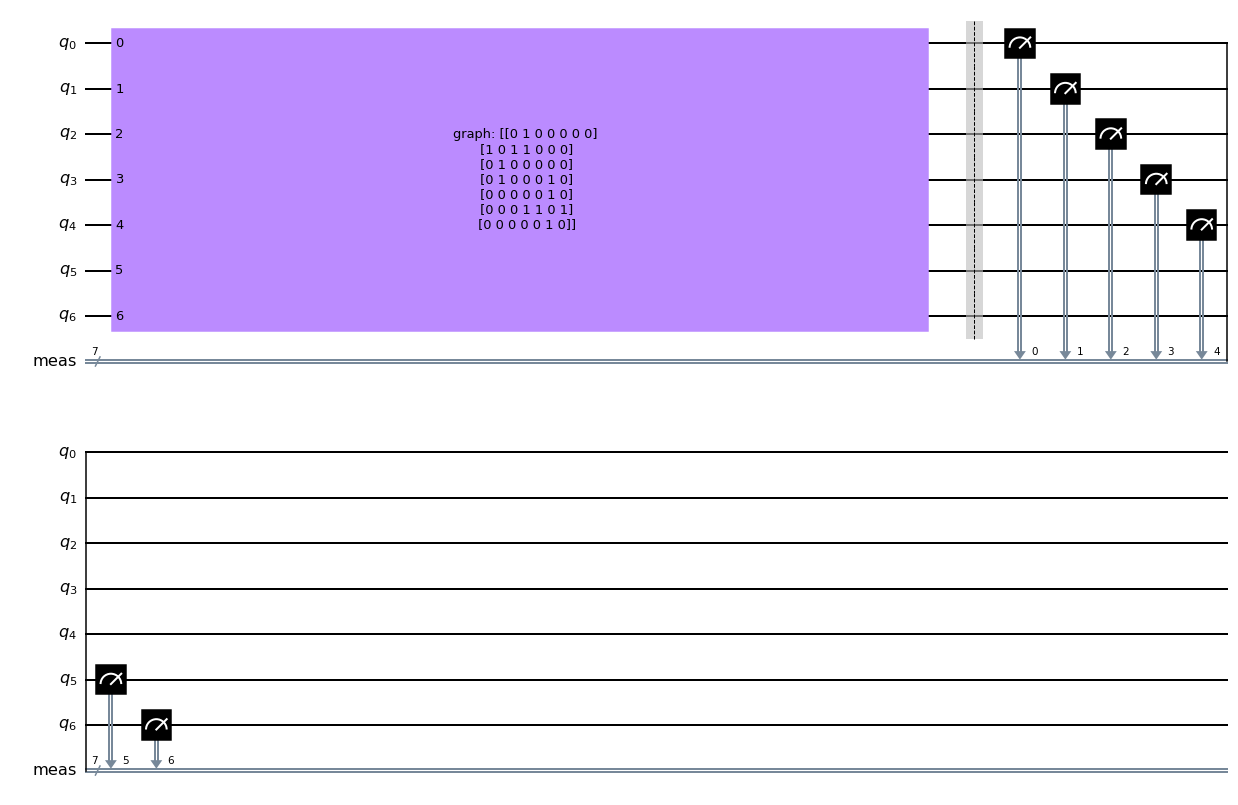

In [12]:
## Append the stabilizer measurements to the graph state circuit 
stabilizer_circuits = [stabilizer_measure_circuit(stab, state_circuit)
                       for stab in stabilizers]

stabilizer_circuits[0].draw()

#### Measurement Mitigation
Noisy measurements impact our ability to accurately measure the state fidelity. For our default example we calibrate our measurements for the CTMP method using states with two-qubit excitations.


In [13]:
labels = ['0000000', '0000011', '0000101', 
          '0001001', '0001010', '0001100', 
          '0010001', '0010010', '0010100', '0011000', 
          '0100001', '0100010', '0100100', '0101000', '0110000', 
          '1000001', '1000010', '1000100', '1001000', '1010000', '1100000', 
          '1111111']
meas_cal_circuits, metadata = mit.expval_meas_mitigator_circuits(num_qubits, labels=labels)


In [14]:
[meas_cal_circuits_full, state_labels] = mit.complete_meas_cal(range(num_qubits))


#### Run the circuits
We will run the circuits on the ibmq_casablanca quantum system.

In order to debug more quickly and avoid queues, you may consider using a simulator backend modeled after the real quantum system. This will use the noise model of ibmq_casablanca to do simulations. You may uncomment the line below to do so. Note that the fidelities of your graph states will generally be higher on the simulator, but the Open Science Prize is awarded for the best fidelities on the real quantum system.


In [15]:
#backend = QasmSimulator.from_backend(provider.get_backend('ibmq_casablanca'))

In [16]:
IBMQ.load_account() # Load account from disk
IBMQ.providers() 

ibmqfactory.load_account:WARNING:2022-05-19 10:11:02,346: Credentials are already in use. The existing account in the session will be replaced.


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]

In [17]:
from qiskit import IBMQ, assemble, transpile
from qiskit.circuit.random import random_circuit
backend = provider.backend.ibmq_qasm_simulator


In [20]:
reps = 10

In [21]:
all_jobs = []
all_jobs_mit = []

for ii in range(reps):

    # Run QPT on backend
    shots = 8192
    il = [0,1,2,3,4,5,6]
    
    job_backend = execute(stabilizer_circuits, backend, shots=shots, initial_layout=il)
    job_mit_backend = execute(meas_cal_circuits, backend, shots=shots, initial_layout=il)
    print('Job IDs ({}/{}): \n measurement calibration: {}\n stabilizer measurements: {}'.format(
        ii+1, reps, job_mit_backend.job_id(), job_backend.job_id()))

    all_jobs.append(job_backend)
    all_jobs_mit.append(job_mit_backend)

Job IDs (1/10): 
 measurement calibration: 62861869401a4c5107cd3ec4
 stabilizer measurements: 628618659012f54a5ea00901
Job IDs (2/10): 
 measurement calibration: 62861870ae552439eb463c60
 stabilizer measurements: 6286186d2cf47dd2aa384da1
Job IDs (3/10): 
 measurement calibration: 628618772cf47d7640384da3
 stabilizer measurements: 6286187432e9568960da7872
Job IDs (4/10): 
 measurement calibration: 6286187eae552497a8463c61
 stabilizer measurements: 6286187a9012f511f6a00902
Job IDs (5/10): 
 measurement calibration: 62861885d1d86bcf3be4cc83
 stabilizer measurements: 62861882ae5524cd1a463c62
Job IDs (6/10): 
 measurement calibration: 6286188d2cf47dd2ac384da4
 stabilizer measurements: 62861889401a4c7a6ecd3ec5
Job IDs (7/10): 
 measurement calibration: 628618949c5eed85f3c28ec2
 stabilizer measurements: 62861891b2f0f7c32f1b30cb
Job IDs (8/10): 
 measurement calibration: 6286189ab2f0f784d01b30cc
 stabilizer measurements: 628618979c97e951472aa012
Job IDs (9/10): 
 measurement calibration: 62861

In [22]:
for job in all_jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


#### Post Processing and computing fidelities

In [23]:
result_backend = []
result_mit_backend = []
for job in all_jobs:
    # Retrieve results (this may take a while depending on the queue)
    result_backend.append(job.result())
    
for job in all_jobs_mit:
    result_mit_backend.append(job.result())

Finally, we compute the fidelities of the graph states. You may consider creating your own method for error mitigation by updating the stabilizer_expvals function below. Here, we will use the default methods provided in Qiskit.

In [24]:
def stabilizer_measure_diagonal(stabilizer):
    """Return the diagonal vector for a stabilizer measurement.
    
    Args:
        stabilizer (str): a stabilizer string
    
    Returns:
        np.ndarray: the diagonal for measurement in the stabilizer basis.
    """
    coeff, pauli = stabilizer_coeff_pauli(stabilizer)
    diag = np.array([1])
    for s in reversed(pauli):
        if s == 'I':
            tmp = np.array([1, 1])
        else:
            tmp = np.array([1, -1])
        diag = np.kron(tmp, diag)
    return coeff * diag
    
def stabilizer_fidelity(expvals, stddevs=None):
    """Compute stabilizer state fidelity from stabilizer expvals."""
    mean = np.mean(expvals)
    if stddevs is None:
        return mean
    stddev = np.sqrt(np.sum(stddevs ** 2))
    return mean, stddev

In [25]:
def stabilizer_expvals(result, stabilizers, meas_mitigator=None):
    """Compute expectation values from stabilizer measurement results."""

    ### YOUR CODE GOES HERE -- START
    
    expvals = []
    stddevs = []
    for i, stab in enumerate(stabilizers):
        expval, stddev = mit.expectation_value(
            result.get_counts(i),
            diagonal=stabilizer_measure_diagonal(stab),
            meas_mitigator=meas_mitigator)
        expvals.append(expval)
        stddevs.append(stddev)
    return np.array(expvals), np.array(stddevs)

In [26]:
## Mitigate the stabilizer expectation values 
F_nomit_backend = []
F_mit_backend = []

for ii in range(reps):
    # Unmitigated Expectation Values
    expvals_nomit_b, stddevs_nomit_b = stabilizer_expvals(
        result_backend[ii], stabilizers)
  
    # Fit measurement error mitigators
    mitigator_backend = mit.ExpvalMeasMitigatorFitter(result_mit_backend[ii], metadata).fit()

    # Measurement error mitigated expectation values
    expvals_mit_b, stddevs_mit_b = stabilizer_expvals(
        result_backend[ii], stabilizers, meas_mitigator=mitigator_backend)
    
    # save the fidelities for this iteration
    F_nomit_backend.append(stabilizer_fidelity(expvals_nomit_b, stddevs_nomit_b)[0])
    F_mit_backend.append(stabilizer_fidelity(expvals_mit_b, stddevs_mit_b)[0])


In [33]:
## The final results

print('Graph-state fidelity estimates')
print('\nNo mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(properties.backend_name, np.mean(F_nomit_backend), np.std(F_nomit_backend)))

print('\nCTMP error mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(properties.backend_name, np.mean(F_mit_backend), np.std(F_mit_backend)))


Graph-state fidelity estimates

No mitigation

CTMP error mitigation
